# Survival Analysis

* Historically, survival analysis was developed and used by actuaries
and medical researchers to measure the lifetime of populations.
* What's the expected lifetime of patients that were given drug A? drug B?
* What's the life-expectancy of a baby born today in France?

These researchers wanted to measure the duration between *Birth* and *Death*


Source: [Lifelines: Survival Analysis in Python](https://www.youtube.com/watch?v=XQfxndJH4UA)


# Survival function and hazard function

**Definition:** Let $T$ be a random variable called failure time.

- $f(t)$ be its probability density function
- $F(t):=\mathcal{P}(T\le t)$ its cumulative distribution function

Then we define

- The *survival function* $S(t):=\mathcal{P}(T>t)=1-F(t)$.
- The *hazard function* (probability of failure between $t$ and $t+\delta t$ knowing that it was working at time $t$):
$$
h(t):=\lim_{\delta t\to0}\frac{\mathcal{P}(T<t+\delta t|T>t)}{\delta t}=
\lim_{\delta t\to0}\frac{F(t+\delta t)-F(t)}{\delta t}\times\frac{1}{1-F(t)}=\frac{f(t)}{1-F(t)}.
$$

**Properties:**
- $S(t)=\exp(-\int_0^t h(s)\,ds)$.
- $h(t)=-\frac{d}{dt}\ln(S(t))$.

# Right censoring

By the end of the study, the event of interest (for example, in medicine "death of a patient" or "churn of a customer") has only occurred for a subset of the observations.



# Modern Survival Analysis

+ **Birth:** Customer joins Netflix  
**Death:** Customer leaves Netflix  
**Censorship:** At the current time, I cannot see all cancelations  
  
  
+ **Birth:** Leader forms government  
**Death:** Government dissolves  
**Censorship:** Death of leader or current time do not allow me to see all dissolvements  


+ **Birth:** Couple starts dating  
**Death:** Couple breaks-up  
**Censorship:** Some couples never break-up (partner's death comes first)  

First, let's take a dataset from lifelines to see what does it mean in practice.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
plt.style.use('seaborn')

In [2]:
from lifelines.datasets import load_dd

df = load_dd()
df = df[['ctryname', 'un_region_name', 'un_continent_name', 'ehead',\
         'democracy', 'regime', 'start_year', 'duration', 'observed']]

# Democracy and dictatorship

This dataset contains a classification of political regimes as democracy and dictatorship.
* Classification of democracies as 
  + parliamentary, 
  + semi-presidential (mixed), and 
  + presidential. 
  
* Classification of dictatorships as 
  + military, 
  + civilian, and 
  + royal. 
  
Coverage: 202 countries, from 1946 or year of independence to 2008.

**References**

José Antonio Cheibub, Jennifer Gandhi, and James Raymond Vreeland. ["Democracy and Dictatorship Revisited."](https://doi.org/10.1007/s11127-009-9491-2) Public Choice, vol. 143, no. 2-1, pp. 67-101, 2010.

In [3]:
df.tail(10).style.hide_index()

ctryname,un_region_name,un_continent_name,ehead,democracy,regime,start_year,duration,observed
Yugoslavia,Southern Europe,Europe,Stipe Suvar,Non-democracy,Civilian Dict,1988,1,1
Yugoslavia,Southern Europe,Europe,Milan Pancevski,Non-democracy,Civilian Dict,1989,1,1
Yugoslavia,Southern Europe,Europe,Borisav Jovic,Non-democracy,Civilian Dict,1990,1,0
Zambia,Eastern Africa,Africa,Kenneth Kaunda,Non-democracy,Civilian Dict,1964,27,1
Zambia,Eastern Africa,Africa,Frederick Chiluba,Non-democracy,Civilian Dict,1991,11,1
Zambia,Eastern Africa,Africa,Levy Patrick Mwanawasa,Non-democracy,Civilian Dict,2002,6,1
Zambia,Eastern Africa,Africa,Rupiah Bwezani Banda,Non-democracy,Civilian Dict,2008,1,0
Zimbabwe,Eastern Africa,Africa,Ian Smith,Non-democracy,Civilian Dict,1965,14,1
Zimbabwe,Eastern Africa,Africa,Abel Muzorewa,Non-democracy,Civilian Dict,1979,1,1
Zimbabwe,Eastern Africa,Africa,Robert Mugabe,Non-democracy,Civilian Dict,1980,29,0


Let's look at right-censored samples.

In [4]:
format_dict = {'ehead':'{}','duration':'{}', 'observed':'{}'}
(df.query('ctryname == "United States of America"')[['ehead', 'duration', 'observed']].style.format(format_dict)
  .hide_index()
  .highlight_min('observed', color='lightgreen'))

ehead,duration,observed
Harry Truman,7,1
Dwight D. Eisenhower,8,1
John Kennedy,2,0
Lyndon Johnson,6,1
Richard Nixon,5,1
Gerald Ford,3,1
Jimmy Carter,4,1
Ronald Reagan,8,1
George Bush,4,1
Bill Clinton,8,1


In [5]:
print(f'samples: {len(df)}\n')
print(f'right censored samples: {len(df.query("observed == 0"))}')
print(f'right censored samples (%): {100*len(df.query("observed == 0"))/len(df):.1f}%')

samples: 1808

right censored samples: 340
right censored samples (%): 18.8%


# How can we estimate the probability of a government survival?

**Example:** I want to estimate the survival function of a new machine and I have 100 of these new machines. After the first year:

Samples | I 
--- | --- 
Initial numbers | 100 
Deaths in first year of age | 70 
One-year survivors | `30` 

Therefore, a reasonable estimate of the survival probability of 1 year is 0.3.

I have increased my production. So now I have 1000 new machines.

Samples | I | II
--- | --- | ---
Initial numbers | 100 | 1000
Deaths in first year of age | 70 | 750
One-year survivors | `30` | `250`
Deaths in second year of age | 15 | 
Two-year survivors | `15` | 

What would be a good estimate of the survival probability of 1 year? and 2 years?

The estimate of the probability of survival of 1 year would be 
$\hat{P}(1)=(30+250)/(100+1000) \sim 0.255$

$\hat{P}(2|1) = 15/30 = 0.5$

$\hat{P}(2)=0.255\times0.5=0.127$

# Kaplan-Meier estimator

**Definition:** Kaplan-Meier estimator of the survival function is given by

$$
\hat{S}(t):=\prod_{i:t_i\le t}\left(1-\frac{d_i}{n_i}\right)
$$
where $t_i$ is a time where at least one event happened, $d_i$ the number of events that happened at time $t_i$, and $n_i$ the individuals known to have survived up to time $t_i$.

We use the [Kaplan-Meier estimator](https://en.wikipedia.org/wiki/Kaplan?Meier_estimator) to estimate the probability of a government survival.

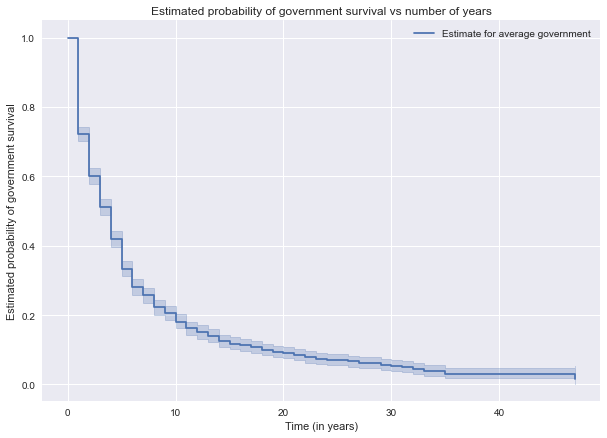

In [6]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(df['duration'],df['observed'], label='Estimate for average government')

fig, ax = plt.subplots(figsize=(10,7))
kmf.plot(ax=ax)
plt.title('Estimated probability of government survival vs number of years')
plt.xlabel('Time (in years)')
plt.ylabel('Estimated probability of government survival')
plt.show()

In [7]:
print(f'The median number of years of government survival is {kmf.median_survival_time_}')

The median number of years of government survival is 4.0


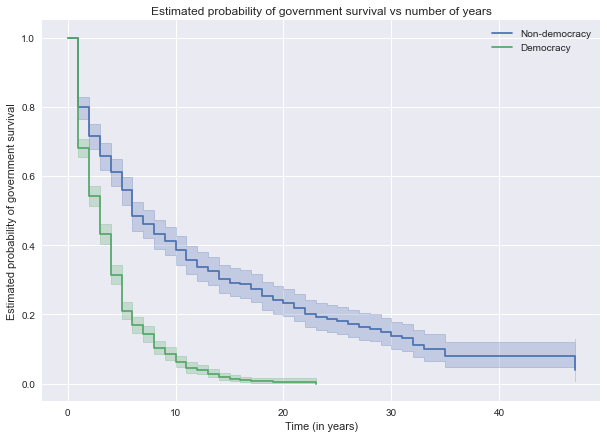

In [8]:
fig, ax = plt.subplots(figsize=(10,7))
for r in df['democracy'].unique():
    ix = df['democracy'] == r
    kmf.fit(df['duration'].loc[ix], df['observed'].loc[ix], label=r)
    kmf.plot(ax=ax)
plt.title('Estimated probability of government survival vs number of years')
plt.xlabel('Time (in years)')
plt.ylabel('Estimated probability of government survival')
plt.show()

In [9]:
for r in df['democracy'].unique():
    ix = df['democracy'] == r
    kmf.fit(df['duration'].loc[ix], df['observed'].loc[ix], label=r)
    print(f'The median number of years for a {r} is {kmf.median_survival_time_}')

The median number of years for a Non-democracy is 6.0
The median number of years for a Democracy is 3.0


How can we tell if these survival functions are different?

# Log-rank test (not recommended but still very common statistical test)

In [10]:
df['democracy'].unique()

array(['Non-democracy', 'Democracy'], dtype=object)

In [11]:
from lifelines.statistics import logrank_test

In [12]:
ix = df['democracy'] == 'Democracy'
T_democracy, E_democracy = df.loc[ix, 'duration'], df.loc[ix, 'observed']
T_non_democracy, E_non_democracy = df.loc[~ix, 'duration'], df.loc[~ix, 'observed']

In [13]:
results = logrank_test(T_democracy, T_non_democracy, event_observed_A=E_democracy, event_observed_B=E_non_democracy)
results.print_summary()

In [14]:
print(results.p_value)
print(results.test_statistic)

1.3557143218483999e-58
260.4695390779592


# Univariate Cox regression

In [15]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
df_Uni_Cox = df.copy()
df_Uni_Cox['indicator'] = df_Uni_Cox['democracy'] == 'Democracy'
cph.fit(df_Uni_Cox[['indicator', 'duration', 'observed']], 'duration', 'observed')
cph.print_summary()

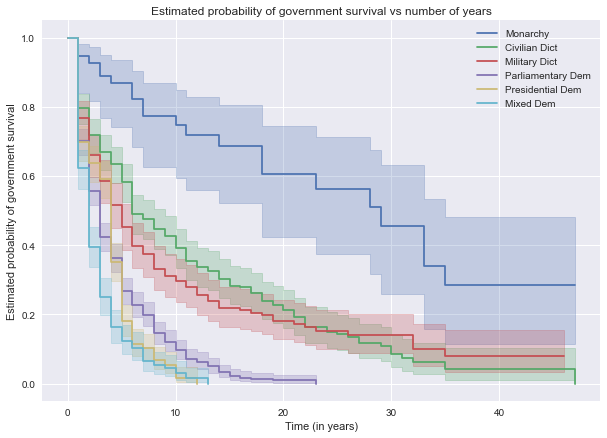

In [17]:
fig, ax = plt.subplots(figsize=(10,7))

for r in df['regime'].unique():
    ix = df['regime'] == r
    kmf.fit(df['duration'].loc[ix], df['observed'].loc[ix], label=r)
    kmf.survival_function_.plot(ax=ax)
plt.title('Estimated probability of government survival vs number of years')
plt.xlabel('Time (in years)')
plt.ylabel('Estimated probability of government survival')
plt.show()

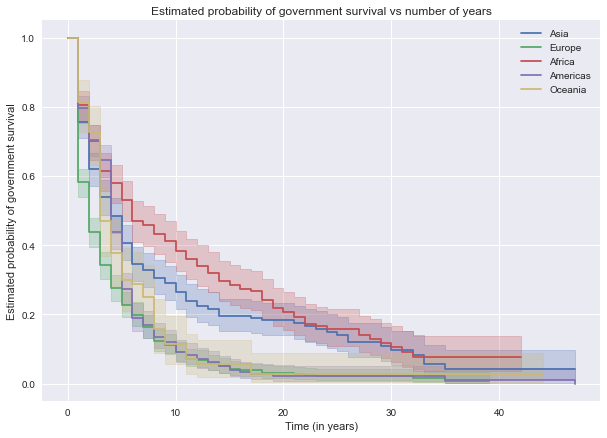

In [18]:
fig, ax = plt.subplots(figsize=(10,7))
for r in df['un_continent_name'].unique():
    ix = df['un_continent_name'] == r
    kmf.fit(df['duration'].loc[ix], df['observed'].loc[ix], label=r)
    kmf.plot(ax=ax)
plt.title('Estimated probability of government survival vs number of years')
plt.xlabel('Time (in years)')
plt.ylabel('Estimated probability of government survival')
plt.show()

In [19]:
df.query('ctryname == "United States of America"').tail(3)

,ctryname,un_region_name,un_continent_name,ehead,democracy,regime,start_year,duration,observed
1721,United States of America,Northern America,Americas,George Bush,Democracy,Presidential Dem,1989,4,1
1722,United States of America,Northern America,Americas,Bill Clinton,Democracy,Presidential Dem,1993,8,1
1723,United States of America,Northern America,Americas,George W. Bush,Democracy,Presidential Dem,2001,8,0


In [20]:
df.query('ctryname == "United Kingdom"').tail(3)

,ctryname,un_region_name,un_continent_name,ehead,democracy,regime,start_year,duration,observed
1710,United Kingdom,Northern Europe,Europe,John Major,Democracy,Parliamentary Dem,1990,7,1
1711,United Kingdom,Northern Europe,Europe,Tony Blair,Democracy,Parliamentary Dem,1997,10,1
1712,United Kingdom,Northern Europe,Europe,Gordon Brown,Democracy,Parliamentary Dem,2007,2,0


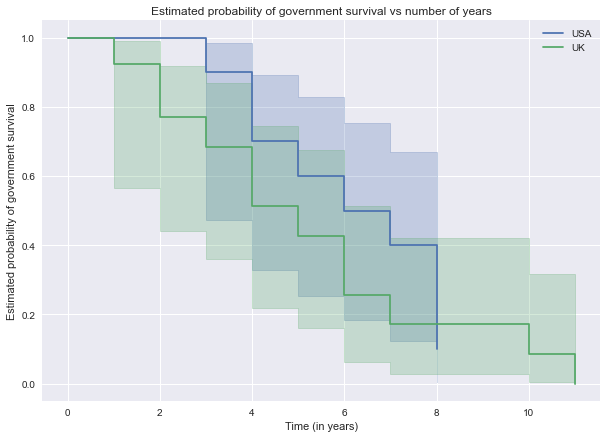

In [21]:
ix_US = df['ctryname'] == 'United States of America'
ix_UK = df['ctryname'] == 'United Kingdom'

kmf_US = KaplanMeierFitter()
kmf_US.fit(df['duration'].loc[ix_US], df['observed'].loc[ix_US], label='USA')

kmf_UK = KaplanMeierFitter()
kmf_UK.fit(df['duration'].loc[ix_UK], df['observed'].loc[ix_UK], label='UK')

plt.figure(figsize=(10,7))
ax = plt.subplot(111)
kmf_US.plot(ax=ax)
kmf_UK.plot(ax=ax)
plt.title('Estimated probability of government survival vs number of years')
plt.xlabel('Time (in years)')
plt.ylabel('Estimated probability of government survival')
plt.show()

In [22]:
df.columns

Index(['ctryname', 'un_region_name', 'un_continent_name', 'ehead', 'democracy',
       'regime', 'start_year', 'duration', 'observed'],
      dtype='object')

In [23]:
df = df.drop(columns=['ctryname', 'un_region_name', 'ehead', 'regime', 'start_year'])

In [24]:
df.columns

Index(['un_continent_name', 'democracy', 'duration', 'observed'], dtype='object')

In [25]:
# df_hazard = pd.get_dummies(df, drop_first=True, columns=df.columns.drop(['duration', 'observed']))
df_hazard = pd.get_dummies(df, columns=df.columns.drop(['duration', 'observed']))

In [26]:
df_hazard.columns

Index(['duration', 'observed', 'un_continent_name_Africa',
       'un_continent_name_Americas', 'un_continent_name_Asia',
       'un_continent_name_Europe', 'un_continent_name_Oceania',
       'democracy_Democracy', 'democracy_Non-democracy'],
      dtype='object')

In [27]:
df_hazard = df_hazard.drop(columns=['un_continent_name_Americas', 'democracy_Democracy'])

In [28]:
df_hazard.columns

Index(['duration', 'observed', 'un_continent_name_Africa',
       'un_continent_name_Asia', 'un_continent_name_Europe',
       'un_continent_name_Oceania', 'democracy_Non-democracy'],
      dtype='object')

# Multivariate Cox regression

In [29]:
from lifelines import CoxPHFitter

cph = CoxPHFitter(penalizer=0.1)
cph.fit(df_hazard, 'duration', 'observed')
cph.print_summary()

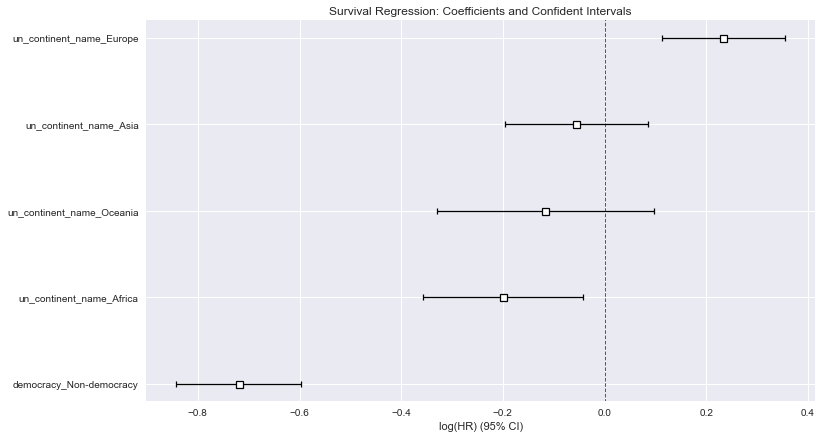

In [30]:
fig_coef, ax_coef = plt.subplots(figsize=(12,7))
ax_coef.set_title('Survival Regression: Coefficients and Confident Intervals')
cph.plot(ax=ax_coef)
plt.show()